<a href="https://colab.research.google.com/github/babi2707/Trabalho-PAI---Reconhecimento-Papanicolau/blob/etapa2/algoritmo/backend/Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
# Célula 1:
import zipfile

caminho_pasta_compactada = '/content/sub_images.zip'
caminho_destino = '/content/sub_images'

with zipfile.ZipFile(caminho_pasta_compactada, 'r') as zip_ref:
    zip_ref.extractall(caminho_destino)

In [73]:
# Célula 2:
import os

base_dir = '/content/sub_images/sub_images'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']
for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

In [74]:
# Célula 3:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import os
import numpy as np
from imblearn.over_sampling import SMOTE
import cv2

# Diretório onde estão os dados
data_dir = '/content/sub_images/sub_images'

# Lista para armazenar os nomes dos arquivos e suas respectivas classes
file_names = []
labels = []

# Preencher as listas com os nomes dos arquivos e suas classes correspondentes
classes = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']  # Adicionar os nomes das classes
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        file_names.append(file_path)
        labels.append(class_name)

# Dividir os dados em treino e teste mantendo a proporção de 4:1
train_files, test_files, train_labels, test_labels = train_test_split(
    file_names, labels, test_size=0.2, random_state=42, stratify=labels)

# Função para extrair características de histograma de cor
def extract_histogram_features(image_path, h_bins=16, s_bins=8):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1], None, [h_bins, s_bins], [0, 180, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Extrair características das imagens de treino
train_features = [extract_histogram_features(file_path) for file_path in train_files]

# Aplicar oversampling no conjunto de treino
smote = SMOTE(random_state=42)
train_features, train_labels = smote.fit_resample(np.array(train_features), train_labels)

# Verificar o balanceamento das classes nos conjuntos de treino e teste
unique, counts = np.unique(train_labels, return_counts=True)
print(f'Balanceamento das classes no conjunto de treino:')
for class_name, count in zip(unique, counts):
    print(f'Classe {class_name}: {count} amostras')

unique, counts = np.unique(test_labels, return_counts=True)
print(f'Balanceamento das classes no conjunto de teste:')
for class_name, count in zip(unique, counts):
    print(f'Classe {class_name}: {count} amostras')

# Atualizar o train_files após o oversampling
train_files = [file_names[i] for i in range(len(train_files))]

# Balancear o conjunto de testes via oversampling
balanced_test_files = []
balanced_test_labels = []

# Encontrar a classe majoritária no conjunto de teste
max_test_class_count = max([test_labels.count(c) for c in set(test_labels)])

# Aplicar oversampling em cada classe no conjunto de teste
for class_name in set(test_labels):
    class_test_files = [file for file, label in zip(test_files, test_labels) if label == class_name]
    class_test_labels = [label for label in test_labels if label == class_name]

    # Oversampling
    if len(class_test_files) < max_test_class_count:
        class_test_files, class_test_labels = resample(
            class_test_files, class_test_labels, replace=True, n_samples=max_test_class_count, random_state=42)

    balanced_test_files.extend(class_test_files)
    balanced_test_labels.extend(class_test_labels)

# Verificar o balanceamento das classes no conjunto de teste balanceado
unique, counts = np.unique(balanced_test_labels, return_counts=True)
print(f'Balanceamento das classes no conjunto de teste balanceado:')
for class_name, count in zip(unique, counts):
    print(f'Classe {class_name}: {count} amostras')

Balanceamento das classes no conjunto de treino:
Classe ASC-H: 3395 amostras
Classe ASC-US: 3395 amostras
Classe HSIL: 3395 amostras
Classe LSIL: 3395 amostras
Classe Negative for intraepithelial lesion: 3395 amostras
Classe SCC: 3395 amostras
Balanceamento das classes no conjunto de teste:
Classe ASC-H: 17 amostras
Classe ASC-US: 78 amostras
Classe HSIL: 58 amostras
Classe LSIL: 99 amostras
Classe Negative for intraepithelial lesion: 849 amostras
Classe SCC: 16 amostras
Balanceamento das classes no conjunto de teste balanceado:
Classe ASC-H: 849 amostras
Classe ASC-US: 849 amostras
Classe HSIL: 849 amostras
Classe LSIL: 849 amostras
Classe Negative for intraepithelial lesion: 849 amostras
Classe SCC: 849 amostras


In [75]:
# Célula 4:
import shutil
import os

def split_data(source_dir, train_dir, test_dir):
    for class_name in classes:
        class_dir = os.path.join(source_dir, class_name)
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        for image in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image)
            if image_path in train_files:
                dest_path = os.path.join(train_class_dir, image)
                if not os.path.exists(dest_path):
                    shutil.copy2(image_path, dest_path)
                else:
                    # Renomear o arquivo se já existir
                    base, ext = os.path.splitext(image)
                    new_dest_path = os.path.join(train_class_dir, f"{base}_copy{ext}")
                    shutil.copy2(image_path, new_dest_path)
            elif image_path in balanced_test_files:
                dest_path = os.path.join(test_class_dir, image)
                if not os.path.exists(dest_path):
                    shutil.copy2(image_path, dest_path)
                else:
                    # Renomear o arquivo se já existir
                    base, ext = os.path.splitext(image)
                    new_dest_path = os.path.join(test_class_dir, f"{base}_copy{ext}")
                    shutil.copy2(image_path, new_dest_path)

split_data(data_dir, train_dir, test_dir)

In [83]:
# Célula 5.2 - SVM:
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
import joblib
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def extract_histogram_features(image_path, h_bins=16, s_bins=8):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1], None, [h_bins, s_bins], [0, 180, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

train_features = []
train_labels_hist = []
test_features = []
test_labels_hist = []

for file_path, label in zip(train_files, train_labels):
    features = extract_histogram_features(file_path)
    train_features.append(features)
    train_labels_hist.append(label)

for file_path, label in zip(balanced_test_files, balanced_test_labels):
    features = extract_histogram_features(file_path)
    test_features.append(features)
    test_labels_hist.append(label)

train_features = np.array(train_features)
test_features = np.array(test_features)

# Codificar as classes
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_hist)
test_labels_encoded = label_encoder.transform(test_labels_hist)

# Padronizar as características
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

svm_model = SVC(kernel='linear')
svm_model.fit(train_features_scaled, train_labels_encoded)
joblib.dump(svm_model, '/content/modelo_svm.pkl')

['/content/modelo_svm.pkl']

In [77]:
# Célula 5.3 - Resnet50:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Parameters
img_height, img_width = 100, 100
batch_size = 32
num_classes = 6
class_names = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']

# Data augmentation
# Data augmentation
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,  # Aumentado para 60 graus
    width_shift_range=0.4,  # Aumentado para 0.4
    height_shift_range=0.4,  # Aumentado para 0.4
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen_val_test.flow_from_directory(
    test_dir,  # usando test_dir para validação neste exemplo
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # Reduzindo para 512 unidades
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  # Reduzindo para uma taxa de dropout de 0.4
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Primeira fase de treinamento
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=30
)

# Fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=20
)

test_loss, test_acc = model.evaluate(test_generator)

# Salvar o modelo em um arquivo .h5
model.save('modelo_resnet50.h5')
print(f'Test accuracy: {test_acc}')

Found 6419 images belonging to 6 classes.
Found 504 images belonging to 6 classes.
Found 504 images belonging to 6 classes.
Epoch 1/30
201/201 [==============================] - 32s 142ms/step - loss: 2.7671 - accuracy: 0.2058 - val_loss: 2.7787 - val_accuracy: 0.0417
Epoch 2/30
201/201 [==============================] - 27s 133ms/step - loss: 2.5934 - accuracy: 0.2535 - val_loss: 3.1104 - val_accuracy: 0.0377
Epoch 3/30
201/201 [==============================] - 27s 133ms/step - loss: 2.5117 - accuracy: 0.2962 - val_loss: 2.8166 - val_accuracy: 0.0575
Epoch 4/30
201/201 [==============================] - 26s 131ms/step - loss: 2.4474 - accuracy: 0.3138 - val_loss: 2.7418 - val_accuracy: 0.0615
Epoch 5/30
201/201 [==============================] - 26s 132ms/step - loss: 2.3676 - accuracy: 0.3331 - val_loss: 1.9665 - val_accuracy: 0.6349
Epoch 6/30
201/201 [==============================] - 26s 130ms/step - loss: 2.2874 - accuracy: 0.3659 - val_loss: 2.3930 - val_accuracy: 0.2619
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test accuracy: 0.7321428656578064


In [78]:
# Célula 5.4 - Resnet50 (Binary Classifier)
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# Parameters
img_height, img_width = 100, 100
batch_size = 32
num_classes = 2

# Data augmentation
datagen_train_bin = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val_test_bin = ImageDataGenerator(rescale=1./255)

train_generator_bin = datagen_train_bin.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator_bin = datagen_val_test_bin.flow_from_directory(
    test_dir,  # usando test_dir para validação neste exemplo
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator_bin = datagen_val_test_bin.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Model
base_model_bin = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model_bin.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions_bin = Dense(1, activation='sigmoid')(x)

# Ajuste de aumento de dados para o modelo binário
datagen_train_bin = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

model_bin = Model(inputs=base_model_bin.input, outputs=predictions_bin)

for layer in base_model_bin.layers:
    layer.trainable = False

# Compilar e treinar o modelo binário
model_bin.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_bin = model_bin.fit(
    train_generator_bin,
    steps_per_epoch=len(train_generator_bin),
    validation_data=val_generator_bin,
    validation_steps=len(val_generator_bin),
    epochs=30
)

# Avaliar o modelo binário
test_loss_bin, test_acc_bin = model_bin.evaluate(test_generator_bin)

# Previsões no conjunto de teste binário
predictions_bin = model_bin.predict(test_generator_bin)
predicted_classes_bin = np.where(predictions_bin > 0.5, 1, 0)

true_classes_bin = test_generator_bin.classes
class_labels_bin = list(test_generator_bin.class_indices.keys())

# Métricas de avaliação
binary_accuracy_bin = accuracy_score(true_classes_bin, predicted_classes_bin)
conf_matrix_bin = confusion_matrix(true_classes_bin, predicted_classes_bin)
classification_report_bin = classification_report(true_classes_bin, predicted_classes_bin, target_names=class_labels_bin)

print(f'Binary ResNet50 Classifier Accuracy: {binary_accuracy_bin}')
print('Binary ResNet50 Classifier Confusion Matrix:')
print(conf_matrix_bin)
print('Binary ResNet50 Classifier Classification Report:')
print(classification_report_bin)

# Salvar o modelo binário em um arquivo .h5
model_bin.save('modelo_resnet50_binary.h5')

Found 6419 images belonging to 6 classes.
Found 504 images belonging to 6 classes.
Found 504 images belonging to 6 classes.
Epoch 1/30
201/201 [==============================] - 31s 134ms/step - loss: 0.4208 - accuracy: 0.1028 - val_loss: 1.5704 - val_accuracy: 0.0397
Epoch 2/30
201/201 [==============================] - 26s 130ms/step - loss: -2.1028 - accuracy: 0.1170 - val_loss: -1.4253 - val_accuracy: 0.0357
Epoch 3/30
201/201 [==============================] - 26s 129ms/step - loss: -5.4185 - accuracy: 0.1196 - val_loss: -12.6198 - val_accuracy: 0.0337
Epoch 4/30
201/201 [==============================] - 26s 130ms/step - loss: -9.7751 - accuracy: 0.1214 - val_loss: 0.0740 - val_accuracy: 0.0496
Epoch 5/30
201/201 [==============================] - 26s 129ms/step - loss: -15.3687 - accuracy: 0.1204 - val_loss: 10.0330 - val_accuracy: 0.0357
Epoch 6/30
201/201 [==============================] - 26s 129ms/step - loss: -22.7689 - accuracy: 0.1201 - val_loss: -13.8733 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/trainin

In [ ]:
# Célula 6.2 - SVM:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Classificador binário (classe negativa X demais)
binary_labels_train = np.where(train_labels_encoded == 4, 0, 1)  # 'Negative for intraepithelial lesion' = 4
binary_labels_test = np.where(test_labels_encoded == 4, 0, 1)

svm_binary = SVC(kernel='linear')
svm_binary.fit(train_features_scaled, binary_labels_train)
binary_predictions = svm_binary.predict(test_features_scaled)

# Classificador multiclasse (6 classes)
svm_multiclass = SVC(kernel='linear')
svm_multiclass.fit(train_features_scaled, train_labels_encoded)
multiclass_predictions = svm_multiclass.predict(test_features_scaled)

# Avaliação do classificador binário
binary_accuracy = accuracy_score(binary_labels_test, binary_predictions)
binary_conf_matrix = confusion_matrix(binary_labels_test, binary_predictions)
print('Binary Classifier Accuracy:', binary_accuracy)
print('Binary Classifier Confusion Matrix:')
print(binary_conf_matrix)
print('Binary Classifier Classification Report:')
print(classification_report(binary_labels_test, binary_predictions, target_names=['Negative', 'Others']))

# Avaliação do classificador multiclasse
multiclass_accuracy = accuracy_score(test_labels_encoded, multiclass_predictions)
multiclass_conf_matrix = confusion_matrix(test_labels_encoded, multiclass_predictions)
print('Multiclass Classifier Accuracy:', multiclass_accuracy)
print('Multiclass Classifier Confusion Matrix:')
print(multiclass_conf_matrix)
print('Multiclass Classifier Classification Report:')
print(classification_report(test_labels_encoded, multiclass_predictions, target_names=label_encoder.classes_))

16/16 [==============================] - 2s 57ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ResNet50 Classifier Accuracy: 0.6746031746031746
ResNet50 Classifier Confusion Matrix:
[[  0   0   0   0  17   0]
 [  0   0   2   0  15   0]
 [  0   0   2   1  14   0]
 [  0   0   1   1  15   0]
 [  0   0  28  13 337   0]
 [  0   0   4   3  51   0]]
ResNet50 Classifier Classification Report:
                                     precision    recall  f1-score   support

                              ASC-H       0.00      0.00      0.00        17
                             ASC-US       0.00      0.00      0.00        17
                               HSIL       0.05      0.12      0.07        17
                               LSIL       0.06      0.06      0.06        17
Negative for intraepithelial lesion       0.75      0.89      0.81       378
                                SCC       0.00      0.00      0.00        58

                           accuracy                           0.67       504
                          macro avg       0.14      0.18      0.16       504
            

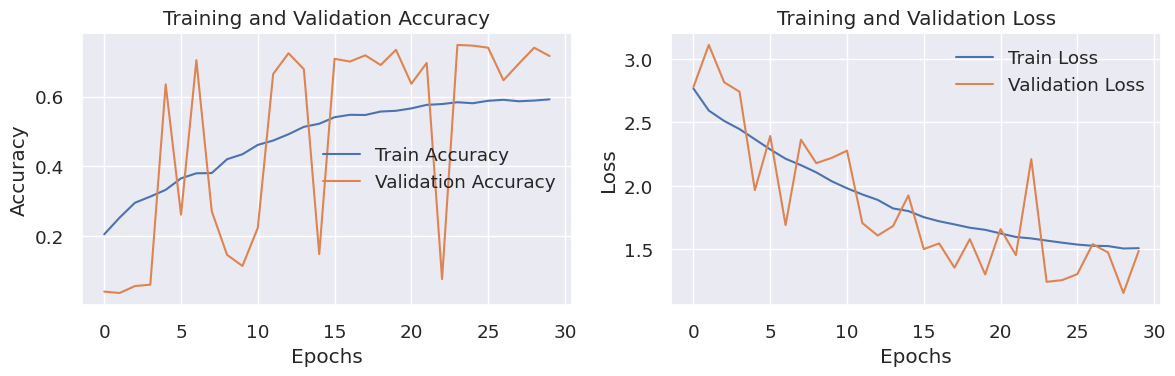

In [80]:
#Célula 6.3 - Resnet50:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import math  # Importar o módulo math

# Função para plotar gráfico de aprendizado
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Previsões no conjunto de teste para ResNet50
test_steps_per_epoch = math.ceil(test_generator.samples / test_generator.batch_size)
predictions_resnet = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes_resnet = np.argmax(predictions_resnet, axis=1)

# True labels para ResNet50
true_classes_resnet = test_generator.classes
class_labels_resnet = list(test_generator.class_indices.keys())

# Acurácia e relatório de classificação para ResNet50
accuracy_resnet = accuracy_score(true_classes_resnet, predicted_classes_resnet)
conf_matrix_resnet = confusion_matrix(true_classes_resnet, predicted_classes_resnet)
classification_report_resnet = classification_report(true_classes_resnet, predicted_classes_resnet, target_names=class_labels_resnet)

print(f'ResNet50 Classifier Accuracy: {accuracy_resnet}')
print('ResNet50 Classifier Confusion Matrix:')
print(conf_matrix_resnet)
print('ResNet50 Classifier Classification Report:')
print(classification_report_resnet)

# Plotar curvas de aprendizado
plot_learning_curves(history)

 3/16 [====>.........................] - ETA: 0s

<ipython-input-81-f7923f7bcb5e>:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


16/16 [==============================] - 1s 35ms/step
ResNet50 Classifier Accuracy: 0.6706349206349206
ResNet50 Classifier Confusion Matrix:
[[  0   0   0   1  16   0]
 [  0   0   1   0  16   0]
 [  0   0   1   0  16   0]
 [  0   0   3   0  14   0]
 [  0   0  27  14 337   0]
 [  0   0   5   3  50   0]]
ResNet50 Classifier Classification Report:
                                     precision    recall  f1-score   support

                              ASC-H       0.00      0.00      0.00        17
                             ASC-US       0.00      0.00      0.00        17
                               HSIL       0.03      0.06      0.04        17
                               LSIL       0.00      0.00      0.00        17
Negative for intraepithelial lesion       0.75      0.89      0.81       378
                                SCC       0.00      0.00      0.00        58

                           accuracy                           0.67       504
                          macro avg

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


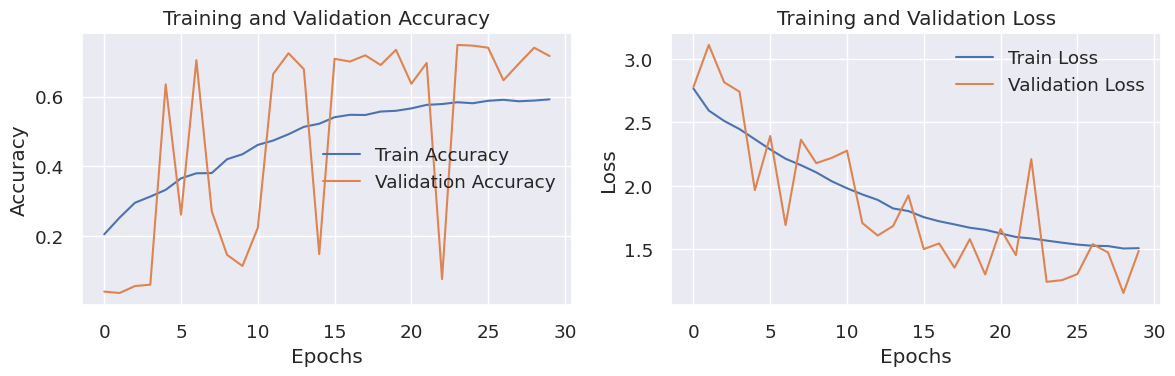

In [81]:
# Célula 7 - Comparação dos Resultados ResNet50

# Previsões no conjunto de teste
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Acurácia e relatório de classificação
accuracy = accuracy_score(true_classes, predicted_classes)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
classification_report_resnet = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(f'ResNet50 Classifier Accuracy: {accuracy}')
print('ResNet50 Classifier Confusion Matrix:')
print(conf_matrix)
print('ResNet50 Classifier Classification Report:')
print(classification_report_resnet)

# Plotar curvas de aprendizado
plot_learning_curves(history)

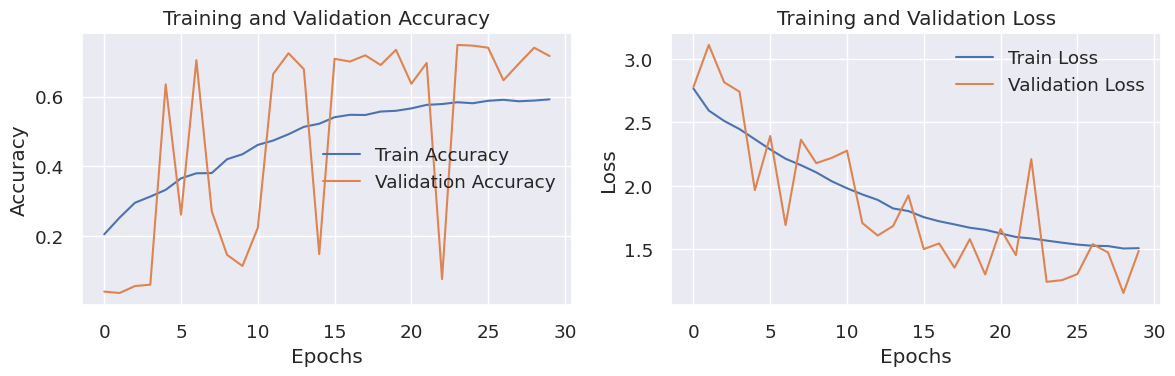

 3/16 [====>.........................] - ETA: 0s

<ipython-input-82-ad40ef64a52b>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


16/16 [==============================] - 1s 37ms/step
ResNet50 Classifier Accuracy: 0.6686507936507936
ResNet50 Classifier Confusion Matrix:
[[  0   0   1   0  16   0]
 [  0   0   1   1  15   0]
 [  0   0   2   0  15   0]
 [  0   0   1   1  15   0]
 [  0   0  28  16 334   0]
 [  0   0   4   0  54   0]]
ResNet50 Classifier Classification Report:
                                     precision    recall  f1-score   support

                              ASC-H       0.00      0.00      0.00        17
                             ASC-US       0.00      0.00      0.00        17
                               HSIL       0.05      0.12      0.07        17
                               LSIL       0.06      0.06      0.06        17
Negative for intraepithelial lesion       0.74      0.88      0.81       378
                                SCC       0.00      0.00      0.00        58

                           accuracy                           0.67       504
                          macro avg

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

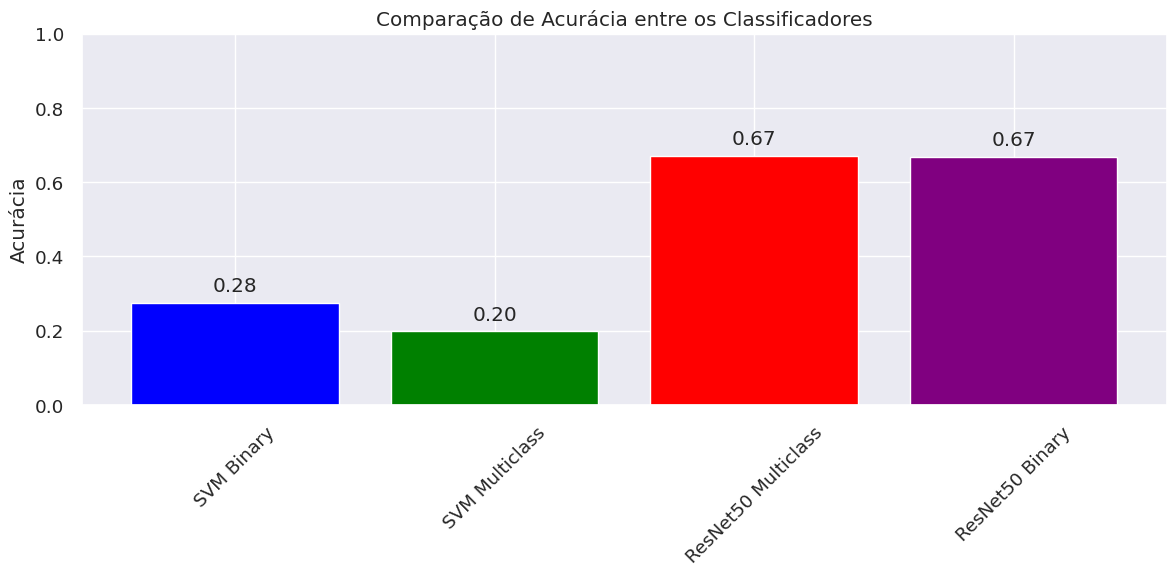

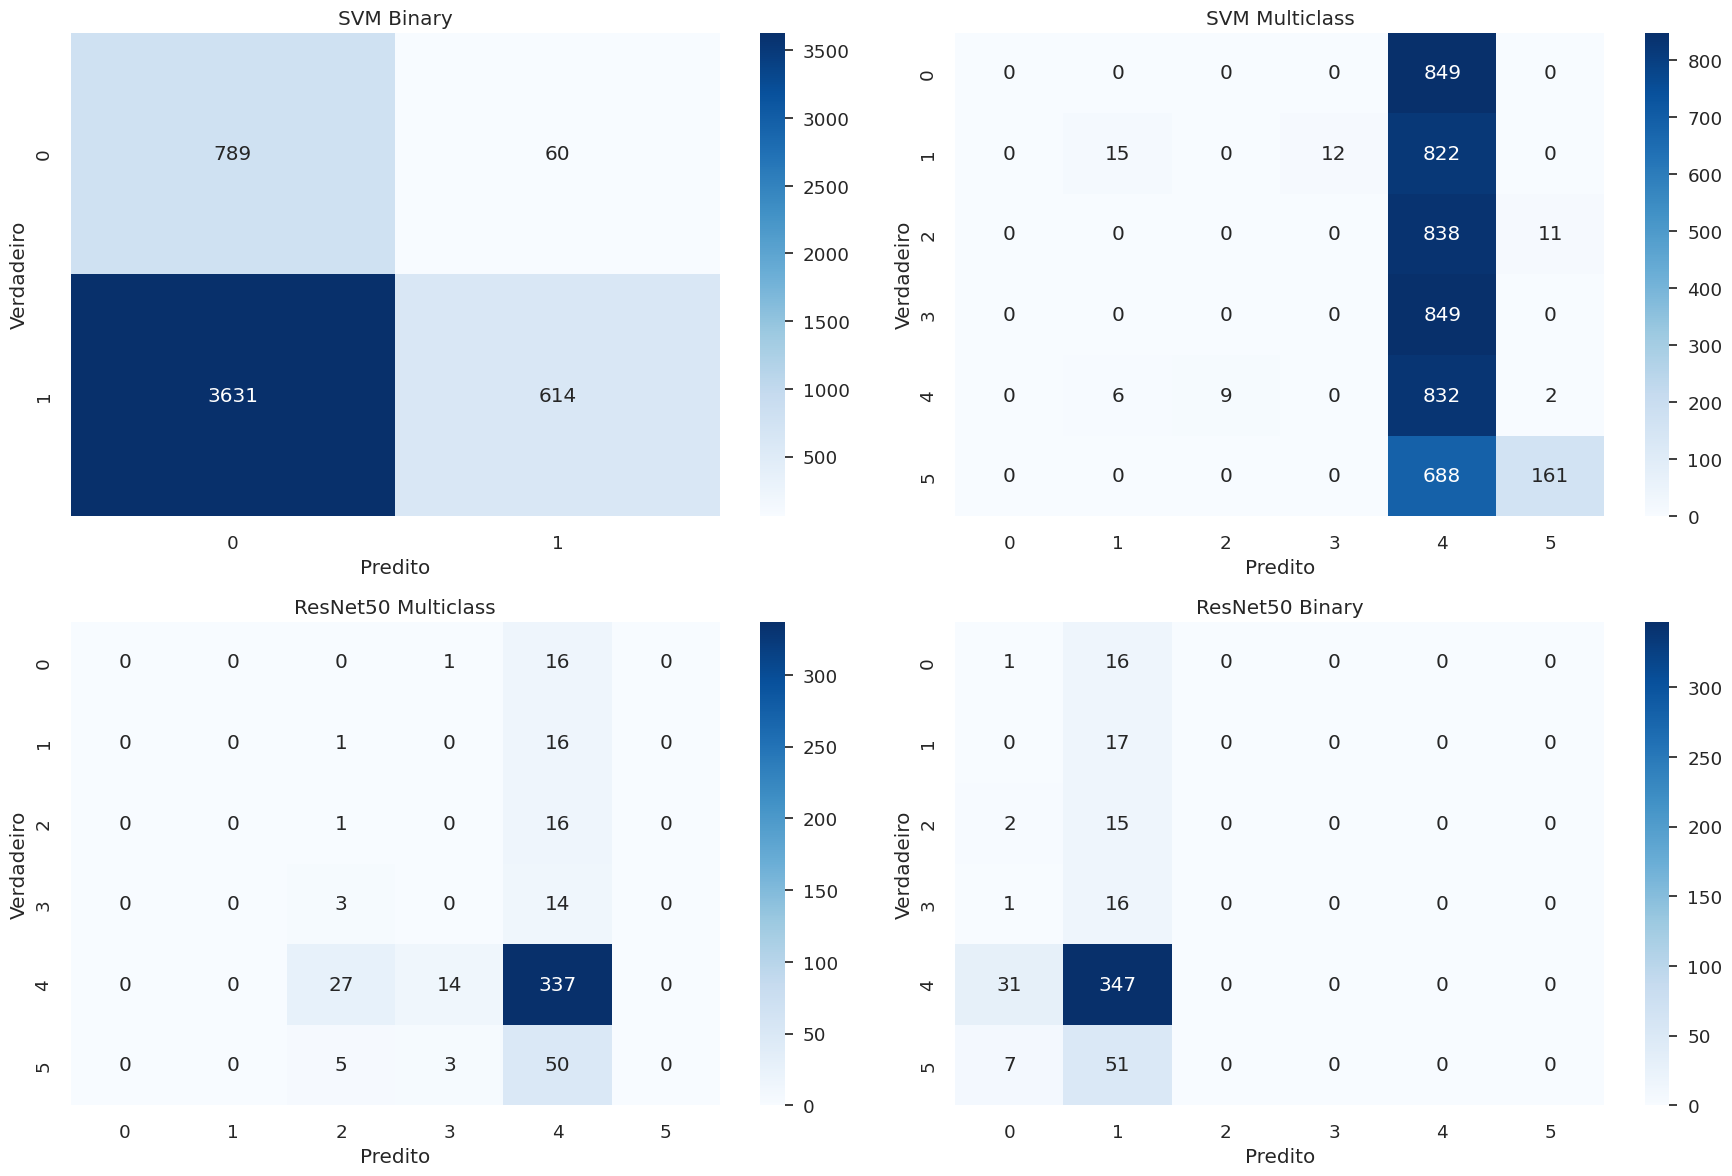

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


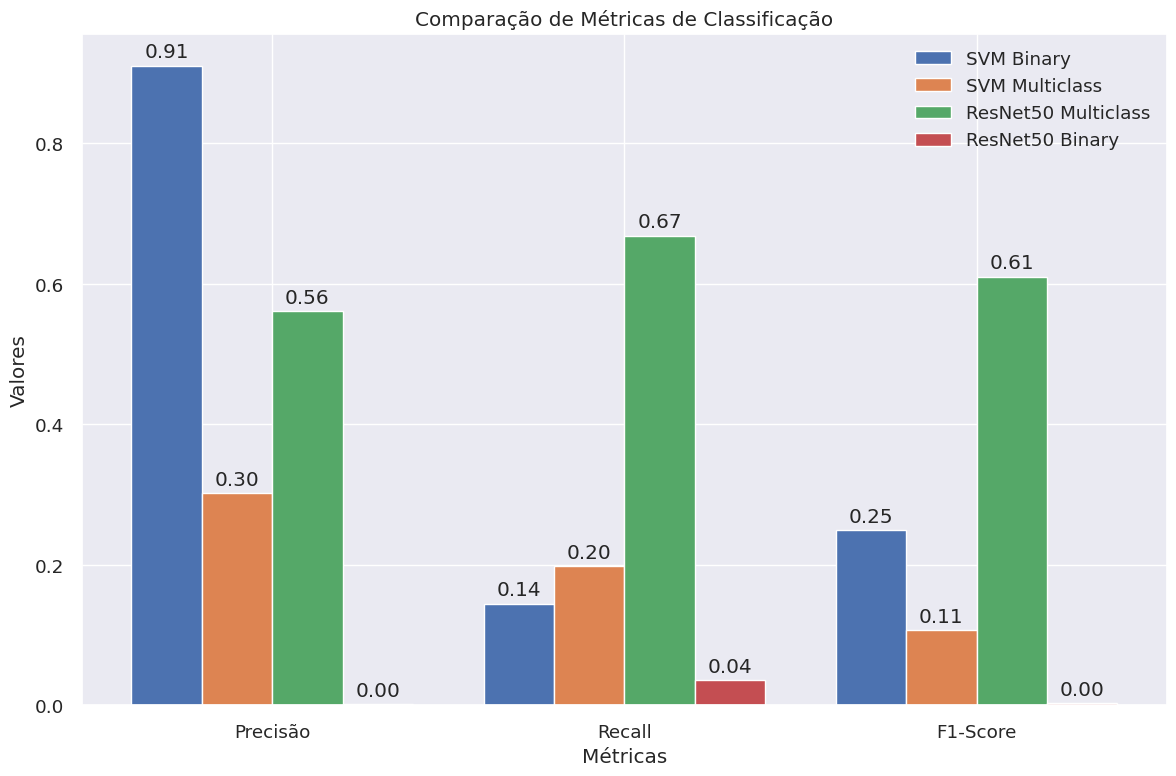

In [82]:
#Célula 8:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report

# Função para plotar gráfico de aprendizado
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotar curvas de aprendizado para ResNet50
plot_learning_curves(history)

# Previsões no conjunto de teste para ResNet50
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions_resnet = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes_resnet = np.argmax(predictions_resnet, axis=1)

# True labels para ResNet50
true_classes_resnet = test_generator.classes
class_labels_resnet = list(test_generator.class_indices.keys())

# Acurácia e relatório de classificação para ResNet50
accuracy_resnet = accuracy_score(true_classes_resnet, predicted_classes_resnet)
conf_matrix_resnet = confusion_matrix(true_classes_resnet, predicted_classes_resnet)
classification_report_resnet = classification_report(true_classes_resnet, predicted_classes_resnet, target_names=class_labels_resnet)

print(f'ResNet50 Classifier Accuracy: {accuracy_resnet}')
print('ResNet50 Classifier Confusion Matrix:')
print(conf_matrix_resnet)
print('ResNet50 Classifier Classification Report:')
print(classification_report_resnet)

# Comparação de Acurácia
print("==== Comparação de Acurácia ====")
print(f'SVM Binary Classifier Accuracy: {binary_accuracy}')
print(f'SVM Multiclass Classifier Accuracy: {multiclass_accuracy}')
print(f'ResNet50 Classifier Accuracy: {accuracy}')
print(f'ResNet50 Binary Classifier Accuracy: {binary_accuracy_bin}')

# Comparação de Matrizes de Confusão
print("\n==== Matrizes de Confusão ====")
print("SVM Binary Classifier Confusion Matrix:")
print(binary_conf_matrix)
print("\nSVM Multiclass Classifier Confusion Matrix:")
print(multiclass_conf_matrix)
print("\nResNet50 Classifier Confusion Matrix:")
print(conf_matrix)
print("\nResNet50 Binary Classifier Confusion Matrix:")
print(conf_matrix_bin)

# Comparação de Relatórios de Classificação
print("\n==== Relatórios de Classificação ====")
print("SVM Binary Classifier Classification Report:")
print(classification_report(binary_labels_test, binary_predictions, target_names=['Negative', 'Others']))
print("\nSVM Multiclass Classifier Classification Report:")
print(classification_report(test_labels_encoded, multiclass_predictions, target_names=label_encoder.classes_))
print("\nResNet50 Classifier Classification Report:")
print(classification_report(true_classes, predicted_classes_resnet, target_names=class_labels_resnet))
# Assuming true_classes_bin and predicted_classes_bin have 6 classes similar to other reports
class_labels_bin = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']

print("\nResNet50 Binary Classifier Classification Report:")
print(classification_report(true_classes_bin, predicted_classes_bin, target_names=class_labels_bin))


# Configurações gerais para os gráficos
plt.style.use('seaborn')
sns.set(font_scale=1.2)

# 1. Gráfico de Barras para Acurácia
accuracies = [binary_accuracy, multiclass_accuracy, accuracy, accuracy_resnet]
models = ['SVM Binary', 'SVM Multiclass', 'ResNet50 Multiclass', 'ResNet50 Binary']

plt.figure(figsize=(12, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre os Classificadores')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Heatmaps para Matrizes de Confusão
conf_matrices = [binary_conf_matrix, multiclass_conf_matrix, conf_matrix, conf_matrix_bin]
titles = ['SVM Binary', 'SVM Multiclass', 'ResNet50 Multiclass', 'ResNet50 Binary']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for ax, conf_matrix, title in zip(axes, conf_matrices, titles):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predito')
    ax.set_ylabel('Verdadeiro')

plt.tight_layout()
plt.show()

# 3. Gráficos de Barras para Métricas de Classificação
# Métricas de classificação: precisão, recall, F1-score
binary_metrics = precision_recall_fscore_support(binary_labels_test, binary_predictions, average='binary')[:3]
multiclass_metrics = precision_recall_fscore_support(test_labels_encoded, multiclass_predictions, average='weighted')[:3]
resnet_metrics = precision_recall_fscore_support(true_classes, predicted_classes_resnet, average='weighted')[:3]
resnet_bin_metrics = precision_recall_fscore_support(true_classes_bin, predicted_classes_bin, average='weighted')[:3]

metrics = ['Precisão', 'Recall', 'F1-Score']
binary_values = [binary_metrics[0], binary_metrics[1], binary_metrics[2]]
multiclass_values = [multiclass_metrics[0], multiclass_metrics[1], multiclass_metrics[2]]
resnet_values = [resnet_metrics[0], resnet_metrics[1], resnet_metrics[2]]
resnet_bin_values = [resnet_bin_metrics[0], resnet_bin_metrics[1], resnet_bin_metrics[2]]

x = np.arange(len(metrics))  # localização dos rótulos
width = 0.2  # largura das barras

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - 1.5*width, binary_values, width, label='SVM Binary')
rects2 = ax.bar(x - 0.5*width, multiclass_values, width, label='SVM Multiclass')
rects3 = ax.bar(x + 0.5*width, resnet_values, width, label='ResNet50 Multiclass')
rects4 = ax.bar(x + 1.5*width, resnet_bin_values, width, label='ResNet50 Binary')

# Adicionar texto para os rótulos
ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparação de Métricas de Classificação')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def autolabel(rects):
    """Anexa um rótulo de texto acima de cada barra, exibindo seu valor."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 pontos de deslocamento vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()